In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

1.

In [2]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
print(type(MA2_process))
print(len(MA2_process))

<class 'numpy.ndarray'>
1000


2.

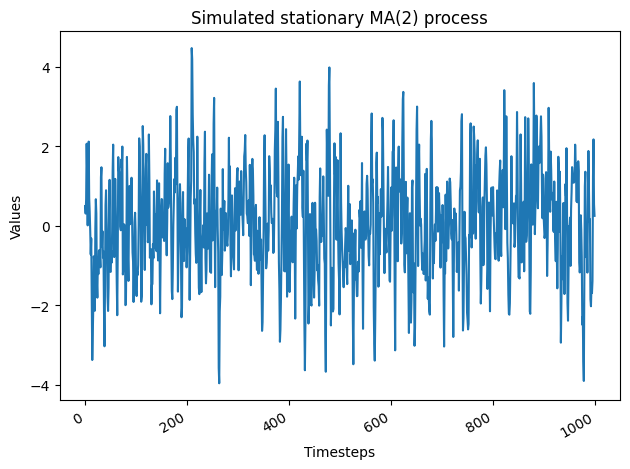

In [3]:
fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

plt.title('Simulated stationary MA(2) process')
fig.autofmt_xdate()
plt.tight_layout()

3.

In [4]:
# Check for stationary
ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# Results show stationarity

ADF Statistic: -14.005444309194495
p-value: 3.7956016167135026e-26


4.

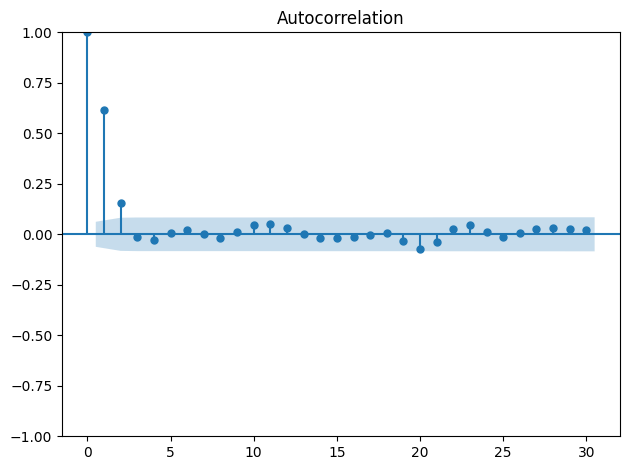

In [5]:
# Being stationary, plot ACF

plot_acf(MA2_process, lags=30)

plt.tight_layout()


5.

In [6]:
# train & test
df = pd.DataFrame({'values': MA2_process})

train = df[:800]
test = df[800:]

print(len(train), len(test))

800 200


6.

In [7]:
# Rolling Forecasting on test set Function

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1)  # no need to predict from zero (0), more efficient to predict from i
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [8]:
# Forecast test set using mean, last value and an MA(2) model.

pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 #2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

print(len(pred_mean), len(pred_df))

200 200


7.

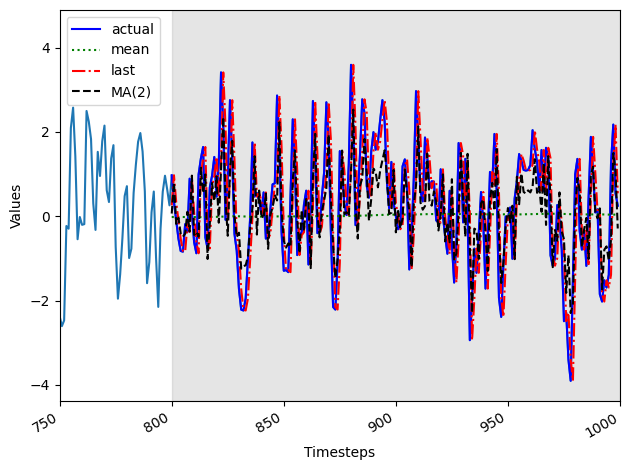

In [9]:
# Plot Forecasts

fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.plot(pred_df['values'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(750, 1000)

fig.autofmt_xdate()
plt.tight_layout()

8.

In [10]:
# MSE

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['values'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['values'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['values'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

1.862200865039332 1.3448230063281528 0.931979931221


Champion model: MA(2)

9.

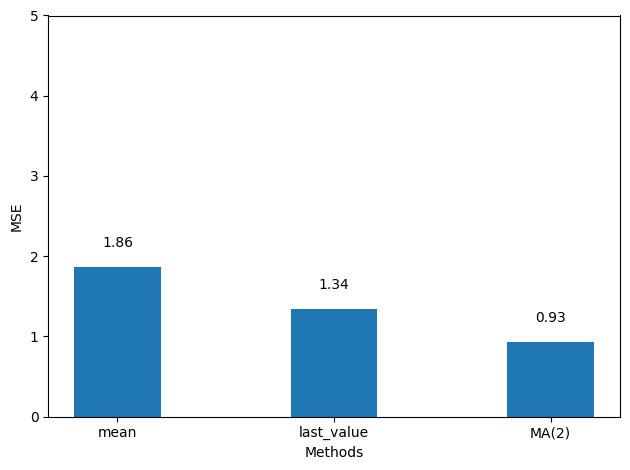

In [11]:
# Plot MSEs

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()